LSTM(Long Short-Term Memory) 구조
- 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러개 가지고 있다.
- 은닉상태는 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만든다.
  이때, 기본 순환층과는 달리 시그모이드 활성화 함수 사용.
  또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만든다.
- 순환되는 상태가 2개.
  은닉상태와 달리 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 셀 상태라고 부르는 값
  ** 셀상태를 계산하는 과정: 1. 먼저 입력과 은닉 상태를 또 다른 가중치에 곱한 다음 시그모이드 함수를 통과시킨다.
                             2. 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다.
                                (이셀 상태가 tanh 함수를 통과하여 새로운 은닉 상태를 만드는데 기여함)
                             3. 여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는데 기여.
                                (이전과 마찬가지고 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, 하나는 시그모이드 함수를 통과시키고
                                 다른 하나는 tanh 함수를 통과시킨 후 두 결과를 곱한 후 이전 셀 상태와 더한 결과가 최종적인 다음 셀 상                                    태가 된다.)


- 삭제게이트: 셀 상태에 있는 정보를 제거
- 입력게이트: 새로운 정보를 셀 상태에 추가
- 출력게이트: 다음 은닉 상태로 출력

LSTM 신경망 훈련하기

In [30]:
# 500개의 단어를 사용하여 훈련세트와 검증 세트 나누기
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [2]:
# 길이를 100으로 맞추고 부족할때는 패딩추가
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [3]:
from tensorflow import keras
model=keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 모델 컴파일, 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history=model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 9ms/step - loss: 0.6926 - accuracy: 0.5319 - val_loss: 0.6918 - val_accuracy: 0.5748
Epoch 2/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6905 - accuracy: 0.6012 - val_loss: 0.6890 - val_accuracy: 0.6174
Epoch 3/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6853 - accuracy: 0.6375 - val_loss: 0.6809 - val_accuracy: 0.6424
Epoch 4/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6603 - accuracy: 0.6370 - val_loss: 0.6291 - val_accuracy: 0.6584
Epoch 5/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5997 - accuracy: 0.7218 - val_loss: 0.5914 - val_accuracy: 0.7376
Epoch 6/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5713 - accuracy: 0.7542 - val_loss: 0.5704 - val_accuracy: 0.7546
Epoch 7/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5519 - accuracy: 0.7653 - val_loss: 0.5532 - val_accuracy: 0.7604

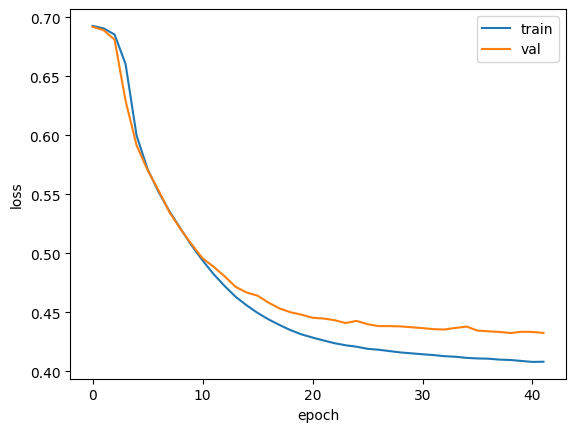

In [6]:
# 훈련손실, 검증손실 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

순환층에 드롭아웃 적용하기
-순환층은 자체적으로 드롭아웃 기능 제공.
-SimpleRNN과 LSTM 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있다.
-dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고, recurrent_dropout(GPU를 사용하여 모델 훈련할수 없음)은 순환되는 은닉상태에 드롭아웃 적용.


In [7]:
model2=keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history=model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 9ms/step - loss: 0.6915 - accuracy: 0.5362 - val_loss: 0.6885 - val_accuracy: 0.6060
Epoch 2/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6836 - accuracy: 0.6222 - val_loss: 0.6745 - val_accuracy: 0.6688
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6398 - accuracy: 0.6878 - val_loss: 0.5992 - val_accuracy: 0.7192
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5819 - accuracy: 0.7190 - val_loss: 0.5681 - val_accuracy: 0.7410
Epoch 5/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5587 - accuracy: 0.7370 - val_loss: 0.5472 - val_accuracy: 0.7578
Epoch 6/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5411 - accuracy: 0.7512 - val_loss: 0.5332 - val_accuracy: 0.7570
Epoch 7/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5270 - accuracy: 0.7590 - val_loss: 0.5180 - val_accuracy: 0.7690

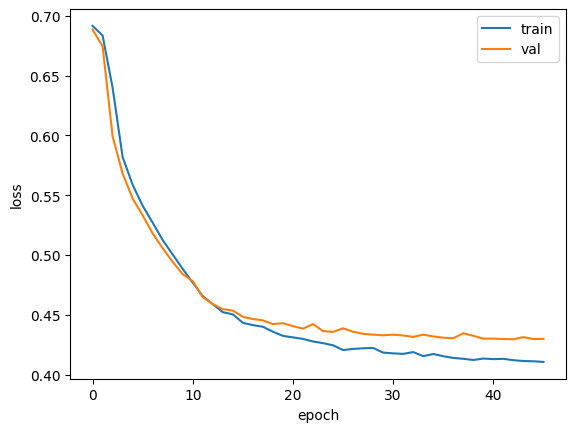

In [9]:
# 훈련손실, 검증손실 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

2개의 층을 연결하기
- 순환층을 쌓게 되면 모든 순환층에 순차 데이터 필요
- 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 함.
- 케라스의 순환층에서 모든 타임스텝의 은닉상태를 출력하려면, 마지막을 제외한 다른 모든 순환층에서 return_sequences 매개변수를 True로 지정.

In [10]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length =100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [11]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 모델 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 7s 14ms/step - loss: 0.6927 - accuracy: 0.5473 - val_loss: 0.6920 - val_accuracy: 0.6106
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6881 - accuracy: 0.6165 - val_loss: 0.6787 - val_accuracy: 0.6608
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6430 - accuracy: 0.6740 - val_loss: 0.6051 - val_accuracy: 0.7122
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5935 - accuracy: 0.7161 - val_loss: 0.5707 - val_accuracy: 0.7358
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5653 - accuracy: 0.7407 - val_loss: 0.5529 - val_accuracy: 0.7476
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5458 - accuracy: 0.7527 - val_loss: 0.5317 - val_accuracy: 0.7614
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5276 - accuracy: 0.7620 - val_loss: 0.5189 - val_accuracy:

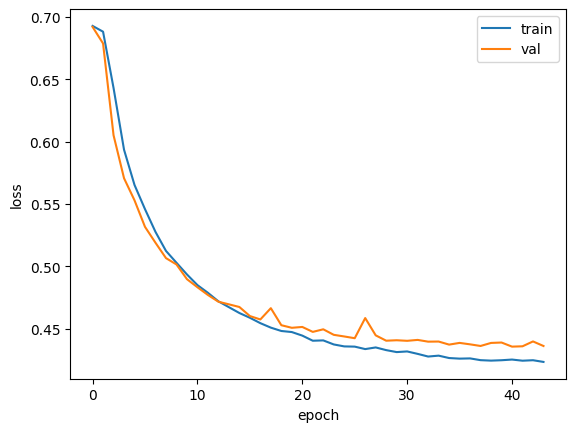

In [16]:
# 손실그래프로 과대적합 제어 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

GRU구조(Gated Recurrent Unit)
- LSTM처럼 셀 상태를 계산하지 않고 은닉상태 하나만 포함
- GRU셀에는 은닉상태와 입력에 가중치를 곱하고 절편을 더하는 작은셀이 3개 들어있고, 3개는 시그모이드 활성화 함수사용 하나는 tang 활성화 함수 사용
- GRU셀은 LSTM보다 가중치가 적기 때문에 계산량이 적다.

In [18]:
# GRU 신경망 훈련하기
model4=keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [19]:
# 모델 구조 확인
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [22]:
# GRU 셀을 사용한 순환 신경망 훈련
remprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer = rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history=model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 4s 9ms/step - loss: 0.6922 - accuracy: 0.5437 - val_loss: 0.6910 - val_accuracy: 0.5728
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6894 - accuracy: 0.5926 - val_loss: 0.6879 - val_accuracy: 0.5906
Epoch 3/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6850 - accuracy: 0.6077 - val_loss: 0.6828 - val_accuracy: 0.6056
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6777 - accuracy: 0.6243 - val_loss: 0.6742 - val_accuracy: 0.6202
Epoch 5/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6652 - accuracy: 0.6412 - val_loss: 0.6591 - val_accuracy: 0.6354
Epoch 6/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6436 - accuracy: 0.6590 - val_loss: 0.6328 - val_accuracy: 0.6636
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6026 - accuracy: 0.6918 - val_loss: 0.5765 - val_accuracy: 0.7170

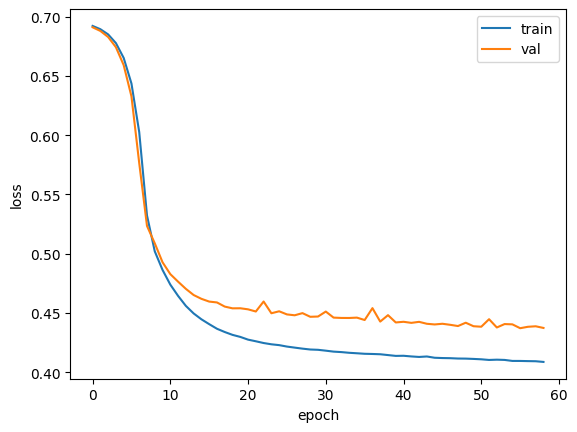

In [23]:
# 손실 그래프 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

LSTM과 GRU셀로 훈련

In [31]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 5s 5ms/step - loss: 0.4307 - accuracy: 0.8000


[0.4306855797767639, 0.8000400066375732]